In [17]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import psutil
import os

In [18]:
# Function to measure memory usage
def memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

In [19]:
df = pd.read_csv('C://Users//Akshat//Desktop//world-cup-26-predictions//data//matches.csv')
print(f"Dataset shape: {df.shape}")

# Preprocessing

df['score'] = df['score'].str.replace('â€"', '-')
label_encoders = {}
categorical_cols = ['tournament_name', 'stage_name', 'group_name', 'home_team_code', 
                    'away_team_code', 'stadium_name', 'city_name', 'country_name']

for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

feature_cols = [col + '_encoded' for col in categorical_cols]
feature_cols += ['group_stage', 'knockout_stage', 'home_team_score', 'away_team_score', 
                'home_team_score_margin', 'away_team_score_margin']

X = df[feature_cols]
y = df['result'].map({'home team win': 0, 'away team win': 1, 'draw': 2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Dataset shape: (1248, 37)
Training set shape: (873, 14)
Test set shape: (375, 14)


In [20]:
performance = {
    'model': [],
    'training_time': [],
    'prediction_time': [],
    'accuracy': [],
    'memory_usage': []
}

In [21]:
# 1. Random Forest Model
print("\n--- Random Forest Model ---")
initial_memory = memory_usage()

# Training time
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_train_time = time.time() - start_time
print(f"Training time: {rf_train_time:.4f} seconds")

# Prediction time
start_time = time.time()
rf_preds = rf_model.predict(X_test)
rf_predict_time = time.time() - start_time
print(f"Prediction time: {rf_predict_time:.4f} seconds")

# Memory usage
rf_memory = memory_usage() - initial_memory
print(f"Memory usage: {rf_memory:.2f} MB")

# Accuracy
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f"Accuracy: {rf_accuracy:.4f}")
print(classification_report(y_test, rf_preds))

performance['model'].append('Random Forest')
performance['training_time'].append(rf_train_time)
performance['prediction_time'].append(rf_predict_time)
performance['accuracy'].append(rf_accuracy)
performance['memory_usage'].append(rf_memory)


--- Random Forest Model ---
Training time: 0.1352 seconds
Prediction time: 0.0130 seconds
Memory usage: 0.02 MB
Accuracy: 0.9813
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       217
           1       0.98      0.95      0.96        97
           2       1.00      1.00      1.00        61

    accuracy                           0.98       375
   macro avg       0.99      0.98      0.98       375
weighted avg       0.98      0.98      0.98       375



In [22]:
# 2. XGBoost Model
print("\n--- XGBoost Model ---")
initial_memory = memory_usage()

# Training time
start_time = time.time()
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_train_time = time.time() - start_time
print(f"Training time: {xgb_train_time:.4f} seconds")

# Prediction time
start_time = time.time()
xgb_preds = xgb_model.predict(X_test)
xgb_predict_time = time.time() - start_time
print(f"Prediction time: {xgb_predict_time:.4f} seconds")

# Memory usage
xgb_memory = memory_usage() - initial_memory
print(f"Memory usage: {xgb_memory:.2f} MB")

# Accuracy
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"Accuracy: {xgb_accuracy:.4f}")
print(classification_report(y_test, xgb_preds))

performance['model'].append('XGBoost')
performance['training_time'].append(xgb_train_time)
performance['prediction_time'].append(xgb_predict_time)
performance['accuracy'].append(xgb_accuracy)
performance['memory_usage'].append(xgb_memory)


--- XGBoost Model ---
Training time: 0.1192 seconds
Prediction time: 0.0060 seconds
Memory usage: 0.20 MB
Accuracy: 0.9707
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       217
           1       0.95      0.94      0.94        97
           2       1.00      1.00      1.00        61

    accuracy                           0.97       375
   macro avg       0.97      0.97      0.97       375
weighted avg       0.97      0.97      0.97       375



In [23]:
comparison_df = pd.DataFrame(performance)
print("\n--- Performance Comparison ---")
print(comparison_df)
print("\n--- Speedup Ratios (RF/XGB) ---")
print(f"Training time ratio: {rf_train_time/xgb_train_time:.2f}x")
print(f"Prediction time ratio: {rf_predict_time/xgb_predict_time:.2f}x")
print(f"Memory usage ratio: {rf_memory/xgb_memory:.2f}x")


--- Performance Comparison ---
           model  training_time  prediction_time  accuracy  memory_usage
0  Random Forest       0.135186         0.012965  0.981333      0.023438
1        XGBoost       0.119231         0.005984  0.970667      0.203125

--- Speedup Ratios (RF/XGB) ---
Training time ratio: 1.13x
Prediction time ratio: 2.17x
Memory usage ratio: 0.12x


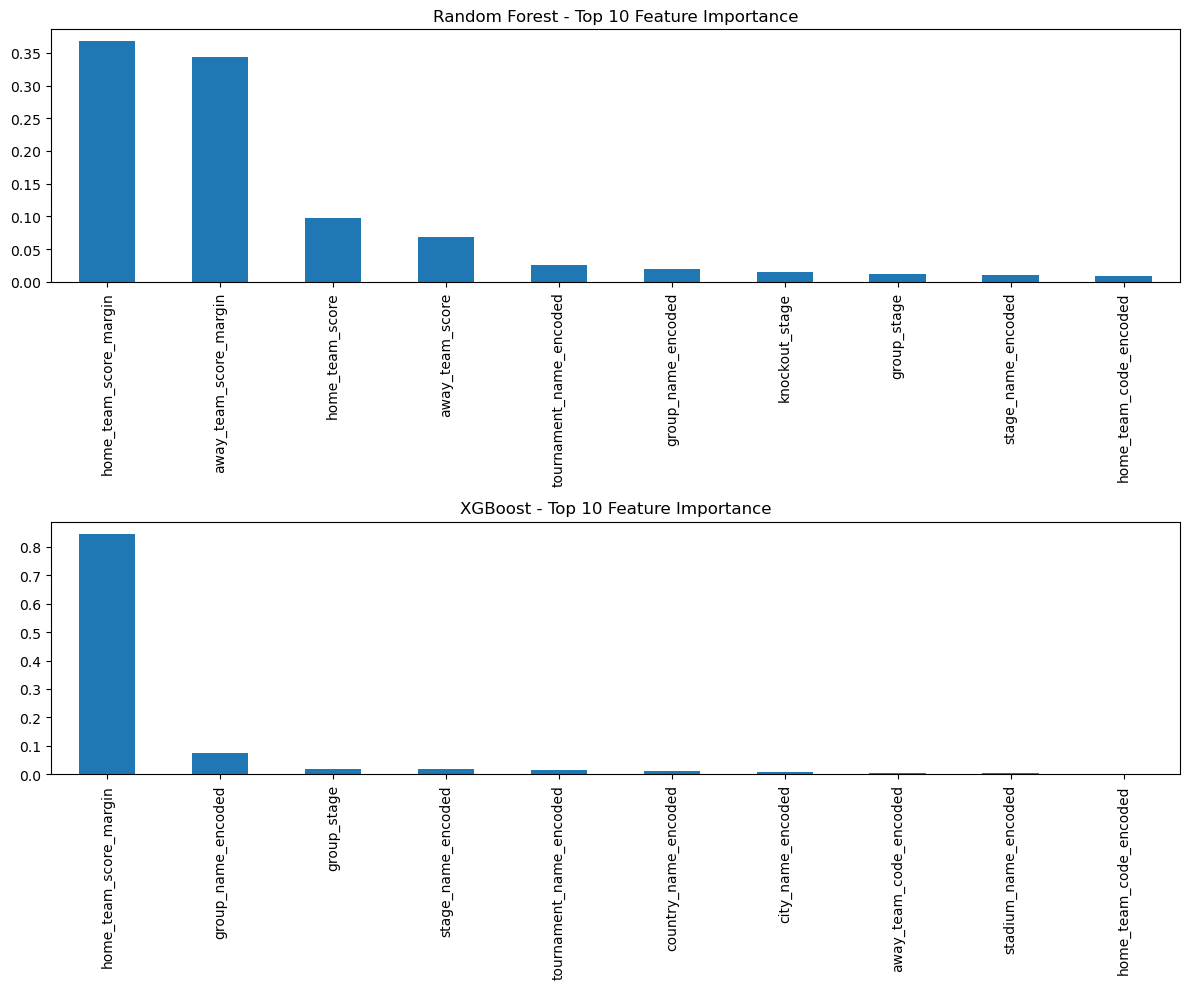

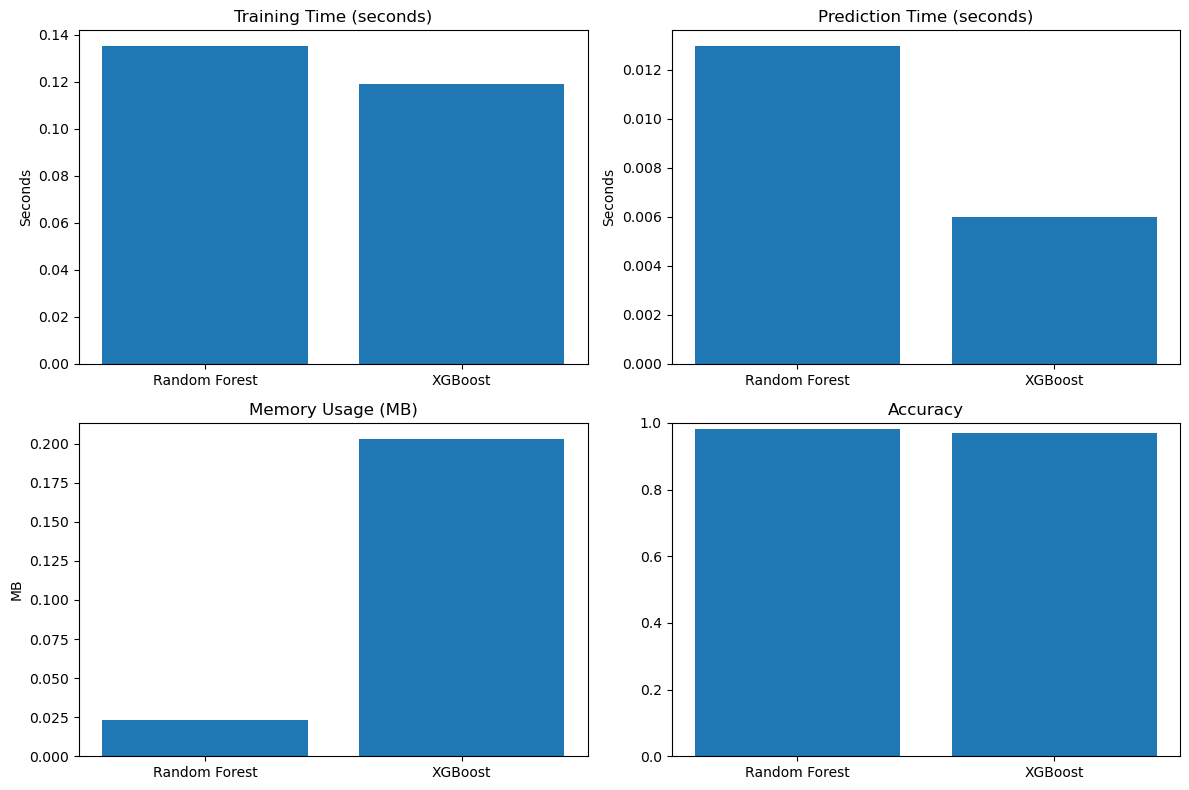

In [25]:
# Feature importance comparison
plt.figure(figsize=(12, 10))

# Random Forest feature importance
plt.subplot(2, 1, 1)
rf_importance = pd.Series(rf_model.feature_importances_, index=feature_cols)
rf_importance = rf_importance.sort_values(ascending=False)
rf_importance.head(10).plot(kind='bar', title='Random Forest - Top 10 Feature Importance')

# XGBoost feature importance
plt.subplot(2, 1, 2)
xgb_importance = pd.Series(xgb_model.feature_importances_, index=feature_cols)
xgb_importance = xgb_importance.sort_values(ascending=False)
xgb_importance.head(10).plot(kind='bar', title='XGBoost - Top 10 Feature Importance')

plt.tight_layout()

# Performance metrics visualization
plt.figure(figsize=(12, 8))

# Training time comparison
plt.subplot(2, 2, 1)
plt.bar(performance['model'], performance['training_time'])
plt.title('Training Time (seconds)')
plt.ylabel('Seconds')

# Prediction time comparison
plt.subplot(2, 2, 2)
plt.bar(performance['model'], performance['prediction_time'])
plt.title('Prediction Time (seconds)')
plt.ylabel('Seconds')

# Memory usage comparison
plt.subplot(2, 2, 3)
plt.bar(performance['model'], performance['memory_usage'])
plt.title('Memory Usage (MB)')
plt.ylabel('MB')

# Accuracy comparison
plt.subplot(2, 2, 4)
plt.bar(performance['model'], performance['accuracy'])
plt.title('Accuracy')
plt.ylim([0, 1])

plt.tight_layout()